## OT - we want to use OT concept to find pairs btwn ctrl and treatment, then using VAE get the transformations. We adjust the latent space of the VAE to introduce hierarchy and get explainability of the perturbations

### Observations and TODOs
- The tree is conditional on the input. Hence, for the same pert, variability of the tree depends on the variability of the input. The latter is defined based on the OT. This is a large limitation of the method. 
- Removing no-pertubation pairs from the dataset leads to a much worse distinguishing of the perturbations. Apparently, model learns a lot of relationships from the no-perturbation pairs. Experiment with how much of the no-perturbation data we add.
- Need to compare binary to multi-branch trees. The latter might be harder to explain but gives more variability.
- Assess the significance and ensure that there is potential for biological findings. Without it, the method is pointless. 
- Explore no-perturbation path, all paths similar to it can be considered as not impactful. TF-based perturbations should not have this path assigned. This is yet another method test.
- Generate multiple records/paths for the same input, assess path stability and common deviations
- Do I need to reconstruct the type of perturbation added as extra dimensions? Would that help the model in any way?
- 

### Imports

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import scanpy as scp
import pandas as pd
import numpy as np
import catboost as cb
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import StratifiedKFold

import ot
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.preprocessing import QuantileTransformer

### Magics

In [3]:
GENE_PER_CELL_BINNING = False
N_BINS = 1000
N_ITER = 50
TOP_N_GENES = 500

### Step 0

In [4]:
adata = scp.read_h5ad('./data/Norman_2019/norman_umi_go/perturb_processed.h5ad')

In [5]:
## Following the scGPT paper, we bin the genes within cell. 

def bin_nonzero_values(arr, num_bins):
    # Filter out non-zero values
    nonzero_vals = arr[arr != 0]
    
    # Calculate bin edges
    bin_edges = np.linspace(nonzero_vals.min(), nonzero_vals.max(), num_bins)
    
    # Bin the values
    binned_values = np.zeros_like(arr)
    binned_nonzero = np.digitize(nonzero_vals, bin_edges)
    binned_values[arr != 0] = binned_nonzero
    
    return binned_values

# Example usage
arr = np.random.randint(low=0, high=100, size=100)
num_bins = 3
binned_values = bin_nonzero_values(arr, num_bins)
print(set(binned_values))

{1, 2, 3}


In [6]:
scp.pp.normalize_total(adata, exclude_highly_expressed=True)
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata, n_top_genes=TOP_N_GENES,subset=True)

In [7]:
if GENE_PER_CELL_BINNING:
    tempy = adata.X.toarray()
    
    for c in tqdm(range(adata.X.shape[0])):
        tempy[c,:] = bin_nonzero_values(tempy[c,:], N_BINS)
    
    adata.X = sparse.csr_matrix(tempy)
    del tempy

In [8]:
y = adata.obs.condition.values.astype(str)
X = adata.X.toarray()

In [9]:
gene_num_map = ['ctrl']
y_processed = []

for rec in tqdm(y):
    y_processed.append([])
    comps = rec.split('+')
    for c in comps:
        if c not in gene_num_map:
            gene_num_map.append(c)
        y_processed[-1].append(gene_num_map.index(c))
    if len(y_processed[-1])<2:
        y_processed[-1].append(gene_num_map.index('ctrl'))

100%|██████████| 91205/91205 [00:00<00:00, 273155.15it/s]


In [10]:
def pair_records_optimal_transport(set1, set2):
    """
    Pairs records from set1 with records from set2 using the optimal transport concept.
    Records from set2 can be used multiple times if needed.

    Args:
    - set1 (np.ndarray): First 2D array of records (shape: n1 x features).
    - set2 (np.ndarray): Second 2D array of records (shape: n2 x features).

    Returns:
    - pairs (list of tuples): List of index pairs (i, j) where i is the index
      from set1 and j is the index from set2 that are paired.
    """

    # Ensure the inputs are numpy arrays
    set1 = np.array(set1)
    set2 = np.array(set2)

    # Compute the cost matrix (Euclidean distance between records)
    cost_matrix = ot.dist(set1, set2, metric='euclidean')

    # Compute the optimal transport plan using linear programming
    n1, n2 = set1.shape[0], set2.shape[0]
    a = np.ones(n1) / n1  # uniform distribution on set1
    b = np.ones(n2)  # flexible distribution on set2

    # Normalize b to sum to the same total mass as a
    b = b / b.sum() * a.sum()

    transport_plan = ot.emd(a, b, cost_matrix)

    # Extract pairs based on the transport plan
    pairs = []
    for i in range(n1):
        j = np.argmax(transport_plan[i])
        pairs.append((i, j))

    return pairs

    
# Example usage
set1 = np.random.rand(20, 5000)  # 100 records with 5000 features each
set2 = np.random.rand(100, 5000)  # 100 records with 5000 features each

pairs = pair_records_optimal_transport(set1, set2)
print(pairs)

[(0, 4), (1, 20), (2, 9), (3, 5), (4, 48), (5, 27), (6, 17), (7, 43), (8, 1), (9, 8), (10, 40), (11, 12), (12, 2), (13, 11), (14, 51), (15, 6), (16, 18), (17, 3), (18, 30), (19, 0)]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_processed, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  )

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  )

In [136]:
def vae_data_prep(X, y):

    # Convert list of lists to a set of tuples to find unique classes
    unique_classes = set(tuple(sorted(yi)) for yi in y)
    
    output_X = []
    output_Y = []
    labels = []
    
    # Convert y to a list of tuples for easier comparison
    y_tuples = [tuple(sorted(yi)) for yi in y]
    
    for c in tqdm(unique_classes):
        # if c == (0,0):
        #     print('skipping no-perturbation records')
        #     continue
        
        set1_indices = [i for i, yi in enumerate(y_tuples) if yi == c]
        set2_indices = [i for i, yi in enumerate(y_tuples) if yi == (0,0)]
        
        set1 = X[set1_indices]
        set2 = X[set2_indices]
        
        pairs = pair_records_optimal_transport(set1, set2)
        
        for p in pairs:
            output_X.append(set2[p[1]])
            output_Y.append(set1[p[0]])
            labels.append(c)
    
    output_X = np.array(output_X)
    output_Y = np.array(output_Y)
    
    return output_X, output_Y, labels

In [137]:
X_trainv, Y_trainv, labels_trainv = vae_data_prep(X_train, y_train)
X_valv, Y_valv, labels_valv = vae_data_prep(X_val, y_val)
X_testv, Y_testv, labels_testv = vae_data_prep(X_test, y_test)

 27%|██▋       | 63/237 [00:14<00:29,  5.84it/s]/hpcfs/users/a1234104/miniconda3/envs/py310torch/lib/python3.10/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 237/237 [00:13<00:00, 17.43it/s]


In [166]:
# pca = PCA(n_components=0.99)

t = np.zeros(shape=(X_trainv.shape[0], 128))
labels_trainv = np.array(labels_trainv)
np.add.at(t, (np.arange(len(labels_trainv)), labels_trainv[:, 0]), 1)
np.add.at(t, (np.arange(len(labels_trainv)), labels_trainv[:, 1]), 1)

X_train_r = np.hstack([X_trainv, t]) #pca.fit_transform(X_trainv)
Y_train_r = np.hstack([Y_trainv, t])
X_train_r[:,TOP_N_GENES+1] = 0

t = np.zeros(shape=(X_valv.shape[0], 128))
labels_valv = np.array(labels_valv)
np.add.at(t, (np.arange(len(labels_valv)), labels_valv[:, 0]), 1)
np.add.at(t, (np.arange(len(labels_valv)), labels_valv[:, 1]), 1)

X_val_r = np.hstack([X_valv, t])#pca.transform(X_valv)
Y_val_r = np.hstack([Y_valv, t])
X_val_r[:,TOP_N_GENES+1] = 0

t = np.zeros(shape=(X_testv.shape[0], 128))
labels_testv = np.array(labels_testv)
np.add.at(t, (np.arange(len(labels_testv)), labels_testv[:, 0]), 1)
np.add.at(t, (np.arange(len(labels_testv)), labels_testv[:, 1]), 1)

X_test_r = np.hstack([X_testv, t])#pca.transform(X_testv)
Y_test_r = np.hstack([Y_testv, t])
X_test_r[:,TOP_N_GENES+1] = 0

In [167]:
# qt = QuantileTransformer(output_distribution='normal',random_state=42,)

# qt.fit(X_train_r)
# X_train_r = qt.transform(X_train_r)
# X_test_r = qt.transform(X_test_r)
# X_val_r = qt.transform(X_val_r)

# Y_train_r = qt.transform(Y_train_r)
# Y_test_r = qt.transform(Y_test_r)
# Y_val_r = qt.transform(Y_val_r)

In [168]:
# model = LGBMClassifier(verbose=-1, n_jobs=10)
# model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc_mu',    callbacks=[
#         lgb.early_stopping(stopping_rounds=100),
#         lgb.log_evaluation(1)
#     ])

In [169]:
device = 'cuda:0'

In [255]:
vae.training

False

In [542]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims, levels):
        super(VAE, self).__init__()

        self.levels = levels
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        self.encoder = self.build_encoder(input_dim, latent_dim, hidden_dims)
        self.decoder = self.build_decoder(latent_dim, input_dim, hidden_dims)
        
        # Initialize the thresholds for the splits
        self.thresholds = torch.randn(2**(self.levels+1)-1).to(device)

    def build_encoder(self, input_dim, latent_dim, hidden_dims):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5)) 
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def build_decoder(self, latent_dim, output_dim, hidden_dims):
        layers = []
        hidden_dims.reverse()
        for h_dim in hidden_dims:
            layers.append(nn.Linear(latent_dim, h_dim))
            layers.append(nn.ReLU())
            latent_dim = h_dim
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if self.training:
            eps = torch.randn_like(std)
        else:
            eps = torch.zeros_like(std)
        return mu + eps * std

    def mask(self, z):
        levels = self.levels
        mask = (z[:, :2**(levels+1)-1] > self.thresholds).float()
        for level in range(1, levels+1):
            nonzero = torch.zeros(z.shape[0]).to(device)
            for i in range(2 ** level - 1, 2 ** (level + 1) - 1):
                if (nonzero > 0).any():
                    mask[nonzero > 0, i] = 0
    
                parent_index = i // 2
                if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
                    mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index - 1]
                else:  # For odd indices, mask if parent (i//2) is masked
                    mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index]
    
                nonzero += mask[:, i]
    
            if (nonzero == 0).any():
                # Calculate differences between node values and thresholds
                differences = torch.abs(z[nonzero == 0, 2 ** level - 1:2 ** (level + 1) - 1] - self.thresholds[2 ** level - 1:2 ** (level + 1) - 1])
                # Find the index of the node with the smallest difference for each record
                min_difference_indices = torch.argmin(differences, dim=1)
                # Activate the node with the smallest difference for each record
                mask[nonzero == 0, 2 ** level - 1 + min_difference_indices] = 1
        
        # we want the first element be always active, after it decides on the child node. This ensures fixed representation length
        mask[:,0] = 1.0
        
        return torch.cat([mask * (z[:,:2**(levels+1)-1]) , z[:,2**(levels+1)-1:]], axis=1)

    # def mask_last_v1(self, z):
    #     levels = self.levels
    #     mask = (z[:, :2**(levels+1)-1] > self.thresholds).float()
    #     for level in range(1, levels+1):
    #         nonzero = torch.zeros(z.shape[0]).to(device)
    #         for i in range(2 ** level - 1, 2 ** (level + 1) - 1):
    #             if (nonzero > 0).any():
    #                 mask[nonzero > 0, i] = 0
    
    #             parent_index = i // 2
    #             if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
    #                 mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index - 1]
    #             else:  # For odd indices, mask if parent (i//2) is masked
    #                 mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index]
                
    #             nonzero += mask[:, i]
                
    #         if (nonzero == 0).any():
    #             mask[nonzero == 0, i] = 1
                
    #     return torch.cat([mask * (z[:,:2**(levels+1)-1]) , z[:,2**(levels+1)-1:]], axis=1)    


    # def mask_v2(self, z):
    #     # Create a binary mask
    #     binary_mask = torch.zeros_like(z[:,:128])
        
    #     # Iterate over each feature in the latent space
    #     for i in range(z[:,:128].size(1)):
    #         # If the feature value is greater than the threshold, set the mask value to 1
    #         binary_mask[:, i] = (z[:, i] > self.thresholds[i]).float()
            
    #         # For odd indices, mask if parent (i//2) is zero
    #         if i % 2 != 0:
    #             binary_mask[:, i] *= (binary_mask[:, i//2] == 0).float()
    #         # For even indices, mask if parent (i//2 - 1) is > 0
    #         elif i % 2 == 0 and i > 0:
    #             binary_mask[:, i] *= (binary_mask[:, i//2 - 1] > 0).float()
        
    #     # Apply the binary mask to the latent space
    #     z_masked = binary_mask * z[:,:128]
        
    #     return torch.cat([z_masked, z[:,128:]], axis=1)

        
    # def mask_v1(self, z):
    #     mask = (z[:,:127] > self.thresholds).float()
    #     for i in range(1, len(mask)):
    #         if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
    #             mask[i] *= mask[i//2 - 1]
    #         else:  # For odd indices, mask if parent (i//2) is masked
    #             mask[i] *= mask[i//2]
                
    #     return torch.cat([mask * z[:,:127], z[:,127:]], axis=1)

    # def mask_v3_working(self,z):
    #     mask = (z[:, :127] > self.thresholds).float()
    #     #mask[:, 0] = 1
    #     for level in range(1, 7):
    #         nonzero = torch.zeros(z.shape[0]).to(device)
    #         for i in range(2 ** level - 1, 2 ** (level + 1) - 1):
    #             #
    #             if (nonzero > 0).any():
    #                 mask[nonzero > 0, i] = 0
    
    #             parent_index = i // 2
    #             if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
    #                 mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index - 1]
    #             else:  # For odd indices, mask if parent (i//2) is masked
    #                 mask[nonzero == 0, i] *= mask[nonzero == 0, parent_index]
                
    #             nonzero += mask[:, i]
                
    #         if (nonzero == 0).any():
    #             mask[nonzero == 0, i] = 1

    #     return torch.cat([mask * (z[:,:127]) , z[:,127:]], axis=1) #* (z[:,:127])
    
    
    # def mask_v11(self, z):
    #     mask = (z[:,:128] > self.thresholds).float()
    #     for level in range(6): 
    #         nonzero = False
    #         for i in range(2**level, 2**(level+1)):
                
    #             if i % 2 == 0:  # For even indices, mask if parent (i//2 - 1) is masked
    #                 mask[i] *= mask[i//2 - 1]
    #             else:  # For odd indices, mask if parent (i//2) is masked
    #                 mask[i] *= mask[i//2]
    #             if mask[i] > 0:
    #                 nonzero = True
    #         if nonzero==False:
    #             mask[i] = 1
    #         else:
    #             nonzero = False
                    
    #     return torch.cat([mask * z[:,:127], z[:,127:]], axis=1)

    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x, perturbs = []):
        mu, logvar = self.encode(x.to(device))
        z = self.reparameterize(mu, logvar)
        z_p = z.clone()

        z[:,:(2**(self.levels+1))-1] *= 0
        z_p = self.mask(z_p)  # Apply the mask before decoding
        
        # Perturbation introduced at the latent space level
        # for pert_n in perturbs:
        #     perturbs_tensor = pert_n.to(device)
    
        #     non_zero_batch_indices = perturbs_tensor.nonzero(as_tuple=False)
        #     dim_pert = perturbs_tensor[non_zero_batch_indices]
        #     dim_pert = dim_pert.type(torch.int16).cpu().numpy()
        #     z_p[non_zero_batch_indices, dim_pert + 128] += 500
        
        pert_x = self.decode(z_p)
        recon_x = self.decode(z)
        
        return pert_x, recon_x, mu, logvar

        
def vae_loss(pert_x, y, recon_x, x, mu, logvar, levels):
    tree_KLD_opt = False
    x = x.to(device)
    recon_loss = nn.functional.mse_loss(recon_x[:,:TOP_N_GENES], x[:,:TOP_N_GENES], reduction='sum')
    pert_loss = nn.functional.mse_loss(pert_x[:,:TOP_N_GENES], y[:,:TOP_N_GENES], reduction='sum')
    if not tree_KLD_opt:
        kl_loss = -0.5 * torch.sum(1 + logvar[:,(2**(levels+1))-1:] - mu[:,(2**(levels+1))-1:].pow(2) - logvar[:,(2**(levels+1))-1:].exp())
    else:
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, pert_loss, kl_loss/100000000.0 #

def train_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3, step_size=5, gamma=0.1, patience=7):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    model.train()
    
    best_loss = 1e6
    
    train_losses = []
    val_losses = []
    no_improve_epochs = 0
    for epoch in range(epochs):
        total_train_recon_loss = 0
        total_train_pert_loss = 0
        total_train_kl_loss = 0
        for batch_ctrl, batch_pert, pert_labels in train_loader:
            optimizer.zero_grad()
            batch_ctrl = batch_ctrl.to(device)
            batch_pert = batch_pert.to(device)
                        
            pert_x, recon_x, mu, logvar = model(batch_ctrl, pert_labels)
            
            z = model.reparameterize(mu, logvar)
            recon_loss, pert_loss, kl_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar, levels=model.levels)
            loss = recon_loss + pert_loss + kl_loss
            loss.backward()
            optimizer.step()
            total_train_recon_loss += recon_loss.item()
            total_train_pert_loss += pert_loss.item()
            total_train_kl_loss += kl_loss.item()
        
        scheduler.step()
        print(f"----Current LR is {scheduler.get_lr()}----")
        avg_train_recon_loss = total_train_recon_loss / len(train_loader.dataset)
        avg_train_pert_loss = total_train_pert_loss / len(train_loader.dataset)
        avg_train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
        train_losses.append((avg_train_recon_loss, avg_train_pert_loss, avg_train_kl_loss))
        
        model.eval()
        total_val_recon_loss = 0
        total_val_pert_loss = 0
        total_val_kl_loss = 0
        with torch.no_grad():
            for batch_ctrl, batch_pert, pert_labels in val_loader:

                batch_ctrl = batch_ctrl.to(device)
                batch_pert = batch_pert.to(device)
                                
                pert_x, recon_x, mu, logvar = model(batch_ctrl, pert_labels)
                z = model.reparameterize(mu, logvar)
                recon_loss, pert_loss, kl_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar, levels=model.levels)
                total_val_recon_loss += recon_loss.item()
                total_val_pert_loss += pert_loss.item()
                total_val_kl_loss += kl_loss.item()
        
        avg_val_recon_loss = total_val_recon_loss / len(val_loader.dataset)
        avg_val_pert_loss = total_val_pert_loss / len(val_loader.dataset)
        avg_val_kl_loss = total_val_kl_loss / len(val_loader.dataset)
        val_losses.append((avg_val_recon_loss, avg_val_pert_loss, avg_val_kl_loss))
        
        current_loss = avg_val_recon_loss + avg_val_pert_loss + avg_val_kl_loss
        if current_loss < best_loss:
            best_loss = current_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        model.train()

        # Plotting the losses
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(10, 7))
        
        # Calculate minimum loss values
        min_train_recon_loss = min([x[0] for x in train_losses])
        min_train_pert_loss = min([x[1] for x in train_losses])
        min_train_kl_loss = min([x[2] for x in train_losses])
        min_val_recon_loss = min([x[0] for x in val_losses])
        min_val_pert_loss = min([x[1] for x in val_losses])
        min_val_kl_loss = min([x[2] for x in val_losses])
        
        # Plot training losses
        ax[0].plot([x[0] for x in train_losses], label='Train Recon Loss')
        ax[0].set_title(f'Min Train Recon Loss: {min_train_recon_loss:.2E}')
        ax[1].plot([x[1] for x in train_losses], label='Train Pert Loss')
        ax[1].set_title(f'Min Train Pert Loss: {min_train_pert_loss:.2E}')
        ax[2].plot([x[2] for x in train_losses], label='Train KL Loss')
        ax[2].set_title(f'Min Train KL Loss: {min_train_kl_loss:.2E}')
        
        # Plot validation losses
        ax[0].plot([x[0] for x in val_losses], label=f'Val Recon Loss; Best: {np.argmin([x[0] for x in val_losses])}')
        ax[0].set_title(f'Min Val Recon Loss: {min_val_recon_loss:.2E}')
        ax[1].plot([x[1] for x in val_losses], label=f'Val Pert Loss; Best: {np.argmin([x[1] for x in val_losses])}')
        ax[1].set_title(f'Min Val Pert Loss: {min_val_pert_loss:.2E}')
        ax[2].plot([x[2] for x in val_losses], label=f'Val KL Loss; Best: {np.argmin([x[2] for x in val_losses])}')
        ax[2].set_title(f'Min Val KL Loss: {min_val_kl_loss:.2E}')
        
        # Add legends
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        plt.show()


In [543]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.labels[idx]

In [604]:
train_dataset = CustomDataset(X_train_r[:,:], Y_train_r[:,:], labels_trainv)
val_dataset = CustomDataset(X_val_r[:,:], Y_val_r[:,:], labels_valv)
test_dataset = CustomDataset(X_test_r[:,:], Y_test_r[:,:], labels_testv)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

input_dim = X_train_r.shape[1]
latent_dim = 600
hidden_dims = [8192,4096]
epochs = 800
learning_rate = 1e-4

In [605]:
vae = VAE(input_dim, latent_dim, hidden_dims, levels=8).to(device)

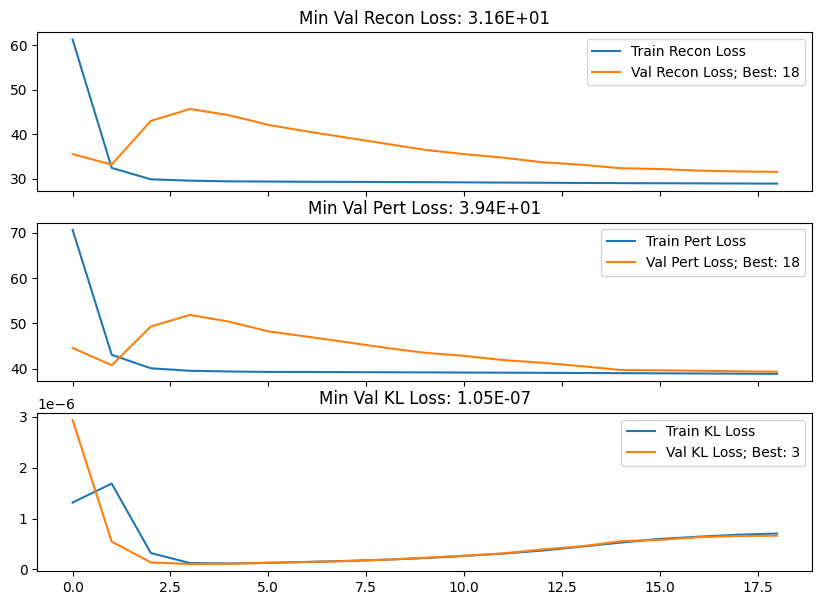

KeyboardInterrupt: 

In [606]:
train_vae(vae, train_loader, val_loader, epochs, learning_rate, gamma=0.7, patience=20)

In [607]:
# For testing, you can run the model in evaluation mode
n_dims_g = 2**(vae.levels+1)-1
vae.eval()
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
        break

In [608]:
pert_labels_s = np.core.defchararray.add(pert_labels[:,0].cpu().numpy().astype(str), '_')
pert_labels_s = np.char.add(pert_labels_s, pert_labels[:,1].cpu().numpy().astype(str))

all_perts = np.unique(pert_labels_s)

for pert in range(all_perts.shape[0]):
    temp = masked_z[pert_labels_s==all_perts[pert]]
    distance_mtx = np.zeros(shape=(temp.shape[0],temp.shape[0]))
    for i in range(temp.shape[0]):
        for j in range(temp.shape[0]):
            
            inds1 = np.arange(temp.shape[1])[(temp[i]!=0)]#[i,-temp.shape[1]:]]
            inds2 = np.arange(temp.shape[1])[(temp[j]!=0)]#[j,-temp.shape[1]:]]
            distance_mtx[i,j] = len(set(inds1.tolist()).intersection(set(inds2.tolist())))
            
    print(all_perts[pert], ':', distance_mtx.mean())

0_0 : 7.19767339360833
0_101 : 7.34319526627219
0_103 : 7.0125
0_14 : 7.058436815193572
0_16 : 7.070528
0_2 : 7.162359991152044
0_23 : 7.261284722222222
0_30 : 7.009162848812995
0_37 : 7.12498348526886
0_39 : 7.070555555555556
0_44 : 6.653333333333333
0_46 : 7.094598226283257
0_48 : 6.975016436554898
0_5 : 7.094215670565615
0_51 : 7.109647944101048
0_53 : 7.233051382401212
0_55 : 6.85207100591716
0_57 : 6.9105098855359
0_60 : 7.142024156601416
0_62 : 7.068809416025351
0_64 : 7.152387559255406
0_69 : 7.288632088148347
0_7 : 7.0142255770068225
0_71 : 7.101320946436347
0_73 : 7.293333333333333
0_78 : 6.9081726354453625
0_80 : 7.114414057339147
0_87 : 7.269134923460306
0_9 : 7.119795471146823
0_94 : 6.667590027700831
10_20 : 7.012152777777778
10_61 : 7.261363636363637
13_35 : 6.964506172839506
15_30 : 7.123109640831758
15_94 : 6.878698224852071
16_17 : 6.774305555555555
16_70 : 6.848074921956296
17_60 : 7.220385674931129
17_87 : 6.879292403746097
17_94 : 7.270408163265306
18_19 : 6.8765432

In [609]:
for i in range(10):
    print(np.arange(n_dims_g)[(masked_z!=0)[i,:]])
print('_______________________')
for i in range(10):
    print(np.arange(n_dims_g)[(masked_z!=0)[-i,:]])

[  0   1   4   9  28  57 115 157 315]
[  0   1   4   9  28  57 115 195 503]
[  0   1   4   9  28  57 115 219 439]
[  0   1   4   9  28  57 115 157 315]
[  0   1   4   9  28  57 115 172 345]
[  0   1   4   9  28  57 115 254 344]
[  0   1   4   9  28  57 115 193 336]
[  0   1   4   9  28  57 115 195 315]
[  0   1   4   9  28  57 115 254 379]
[  0   1   4   9  28  57 115 172 345]
_______________________
[  0   1   4   9  28  57 115 157 315]
[  0   1   4   9  28  57 115 195 336]
[  0   1   4   9  28  57 115 219 439]
[  0   1   4   9  28  57 115 195 426]
[  0   1   4   9  28  57 115 157 315]
[  0   1   4   9  28  57 115 193 467]
[  0   1   4   9  28  57 115 230 461]
[  0   1   4   9  28  57 115 195 255]
[  0   1   4   9  28  57 115 157 315]
[  0   1   4   9  28  57 115 172 345]


In [610]:
n_dims = n_dims_g
paths = []
distance_mtx = np.zeros((512,512))
for i in tqdm(range(512)):
    for j in range(i,512):
        inds1 = np.arange(n_dims)[(masked_z[i, -n_dims:]!=0)]
        inds2 = np.arange(n_dims)[(masked_z[j, -n_dims:]!=0)]
        distance_mtx[i,j] = len(set(inds1.tolist()).intersection(set(inds2.tolist())))#/(min(len(inds1),len(inds2))+1)
        #distance_mtx[i,j] = 2*len(set(inds1.tolist()).intersection(set(inds2.tolist())))/(len(inds1)+len(inds2)+1)

100%|██████████| 512/512 [00:01<00:00, 446.84it/s]


In [611]:
for i in tqdm(range(512)):
    for j in range(i,512):
        distance_mtx[j,i] = distance_mtx[i,j]

100%|██████████| 512/512 [00:00<00:00, 14415.64it/s]


In [612]:
distance_mtx[11:39,11:39].mean(), distance_mtx[:11,:11].mean(), distance_mtx[11:39,:11].mean()

(6.8188775510204085, 7.31404958677686, 6.9772727272727275)

In [613]:
distance_mtx.mean()

7.102867126464844

<Axes: >

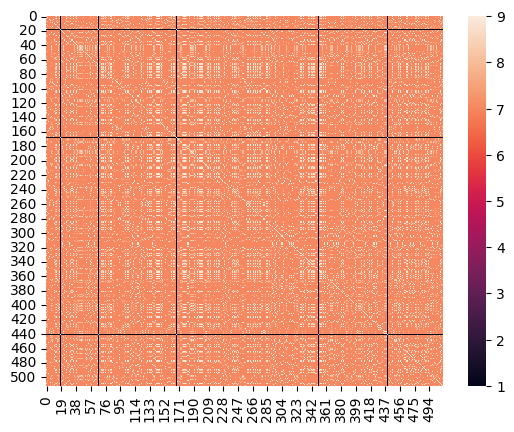

In [614]:
import seaborn as sns
sns.heatmap(distance_mtx)

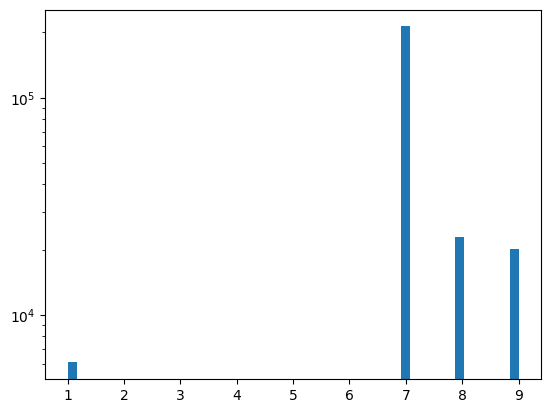

In [615]:
plt.hist(distance_mtx.ravel(),bins=50, log=True);

### Let's get a UMAP of this and see whether clusters resemble the perturbations

In [271]:
# For testing, you can run the model in evaluation mode
vae.eval()
masked_z = []
first_all = []
second_all = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        t_masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
        masked_z.append(t_masked_z)
        first_all.extend(pert_labels[:,0].cpu().numpy()) 
        second_all.extend(pert_labels[:,1].cpu().numpy()) 

In [272]:
z = np.vstack(masked_z)

In [273]:
first = first_all
second = second_all
colors = []
for i in range(len(first)):
    colors.append(str(int(first[i]))+'_'+str(int(second[i])))

unique_colors = np.unique(colors)
color_map = {color: i for i, color in enumerate(unique_colors)}

# Convert colors to numeric values
numeric_colors = np.array([color_map[color] for color in colors])

In [274]:
import umap.umap_ as umap

# Apply UMAP
reducer = umap.UMAP(n_components=2,)
embedding = reducer.fit_transform(z[:,:])

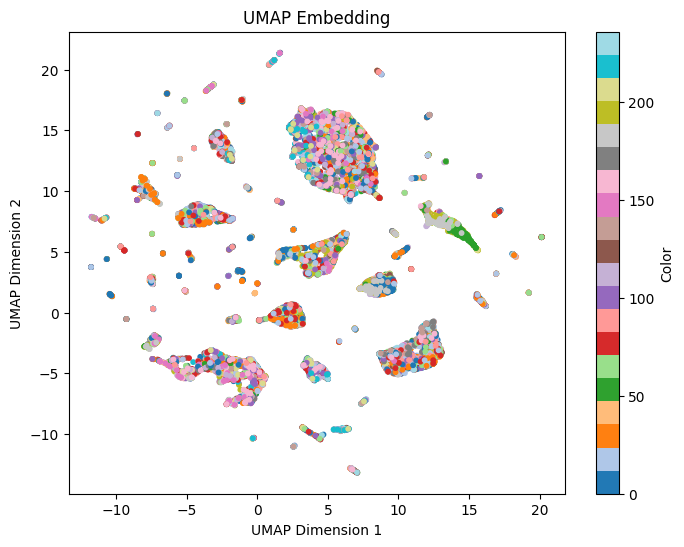

In [276]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=numeric_colors, cmap='tab20', s=10,alpha=0.99)
plt.title("UMAP Embedding")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Color")
plt.show()

### Let's explore how the no-perturbation records look like

In [622]:
# For testing, you can run the model in evaluation mode
vae.eval()
masked_z = []
first_all = []
second_all = []
inputs = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in test_loader:
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        t_masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
        masked_z.append(t_masked_z)
        first_all.extend(pert_labels[:,0].cpu().numpy()) 
        second_all.extend(pert_labels[:,1].cpu().numpy()) 
        inputs.extend(batch_ctrl.cpu().numpy()) 
        
first = first_all
second = second_all
colors = []
for i in range(len(first)):
    colors.append(str(int(first[i]))+'_'+str(int(second[i])))
colors = np.array(colors)
masked_z = np.vstack(masked_z)
inputs = np.vstack(inputs)

In [623]:
masked_z[masked_z!=0] = 1

In [624]:
np.unique(masked_z,axis=0).shape

(81, 511)

In [ ]:
import numpy as np

def identify_contrast_features(masked_z, colors, target_class, threshold=0.1):
    """
    Identifies binary features that show a contrast between the target class and other classes.

    Args:
        masked_z (np.ndarray): Binary 2D array with shape (n_samples, n_features).
        colors (np.ndarray): 1D array of class labels (e.g., [0, 1, 2, ...]).
        target_class (int): The class for which to identify contrast features.
        threshold (float, optional): Minimum difference in feature activation between target class and other classes.
            Defaults to 0.1.

    Returns:
        list: List of indices corresponding to contrast features for the target class.
    """
    # Initialize an empty list to store contrast feature indices
    contrast_feature_indices = []

    # Get the feature values for the target class
    feature_values_for_target = masked_z[colors == target_class]
    
    # Calculate the proportion of active features for the target class
    target_class_proportion = np.mean(feature_values_for_target, axis=0)
    # Iterate over each feature
    for feature_idx in range(masked_z.shape[1]):
        # Get the feature values for all other classes
        other_classes = np.unique(colors[colors != target_class])
        other_feature_values = masked_z[colors != target_class, feature_idx]

        # Calculate the proportion of active features for other classes
        other_classes_proportion = np.mean(other_feature_values, axis=0)

        # Calculate the difference in proportions
        difference = target_class_proportion[feature_idx] - other_classes_proportion
        
        # Check if the difference exceeds the threshold
        if difference > threshold:
            contrast_feature_indices.append((feature_idx, difference))

    return contrast_feature_indices


for c in list(set(colors)):
    print(c, identify_contrast_features(masked_z, colors, c))

0_34 []
10_53 []
0_99 []
0_12 []
17_70 []
17_65 []
0_0 []
13_87 [(202, 0.13514793), (405, 0.13247511)]
0_39 []
43_102 []
7_8 []
9_61 []
0_105 []
0_10 []
10_20 []
0_55 []
0_45 []
56_79 [(202, 0.13682917), (254, 0.24989359), (405, 0.13415909)]
0_82 []
15_30 []
0_62 []
16_17 []
0_73 []
0_91 []
0_33 []
29_48 []
27_28 [(195, 0.10375811)]
0_23 []
0_76 []
0_69 []
0_28 []
55_79 [(172, 0.124328874), (345, 0.124328874)]
0_67 []
41_65 [(254, 0.12827417)]
42_87 [(254, 0.13163114)]
0_46 []
0_86 []
20_61 []
0_6 []
18_80 [(254, 0.121027365)]
15_27 []
16_53 [(219, 0.101515554), (439, 0.101515554)]
20_37 []
43_50 []
75_76 [(195, 0.14090353)]
0_75 []
29_67 []
11_12 []
98_104 []
0_14 []
71_80 [(202, 0.111972414), (405, 0.109299496)]
0_70 []
35_79 [(254, 0.11378648)]
0_36 []
9_20 [(193, 0.10113688)]
3_14 []
10_64 []
0_96 []
0_103 []
0_29 []
0_41 []
0_17 []
16_41 []
42_94 [(172, 0.15163264), (254, 0.24989359), (345, 0.15163264), (371, 0.11912616)]
0_81 []
26_89 []
59_98 [(254, 0.20440248)]
34_45 []
0_95 []

In [630]:
from collections import Counter
Counter(colors)

Counter({'0_0': 2146,
         '0_2': 496,
         '0_25': 357,
         '0_4': 350,
         '4_5': 314,
         '0_10': 306,
         '0_16': 290,
         '12_31': 267,
         '0_41': 258,
         '0_32': 252,
         '10_53': 251,
         '0_15': 246,
         '0_80': 241,
         '0_66': 237,
         '0_18': 227,
         '0_3': 227,
         '0_22': 225,
         '0_64': 217,
         '0_29': 217,
         '0_71': 207,
         '0_13': 207,
         '0_26': 195,
         '0_5': 190,
         '10_13': 189,
         '0_60': 187,
         '0_61': 187,
         '16_41': 184,
         '0_35': 183,
         '0_37': 182,
         '0_81': 181,
         '0_24': 177,
         '0_31': 175,
         '0_12': 172,
         '0_42': 171,
         '58_72': 171,
         '15_30': 169,
         '2_29': 169,
         '4_29': 169,
         '0_53': 168,
         '0_89': 167,
         '0_45': 166,
         '0_9': 164,
         '0_74': 162,
         '15_27': 161,
         '3_27': 157,
         

In [398]:
target_pert = masked_z[colors == '0_0']
last = []
print(target_pert.shape[0])
for i in range(target_pert.shape[0]):
    last.append(np.arange(n_dims_g)[(target_pert!=0)[i,:]][-1])
len(set(last))

2146


2

In [296]:
target_pert = masked_z[:10]
for i in range(target_pert.shape[0]):
    print(np.arange(n_dims_g)[(target_pert!=0)[i,:]])

[ 1  3  7 15 31 63]
[ 2  5 11 24 40 81]
[ 1  3  7 15 31 63]
[ 2  5 11 24 36 73]
[ 2  5 11 23 47 95]
[ 2  5 11 23 47 95]
[ 2  5 11 23 47 95]
[ 1  3  7 15 31 63]
[ 1  3 10 21 43 87]
[ 2  5 11 23 47 95]


In [303]:
np.mean(np.abs(inputs[4] - inputs[5])), np.mean(np.abs(inputs[0] - inputs[2])), np.mean(np.abs(inputs[0] - inputs[1]))

(0.12841444, 0.12897287, 0.1362692)

This points at the fact that the latent representation is largely conditional on the input gene expressions and not necessarily perturbation itself.

### Let's spam latent representations for every record and check how stable the tree paths are

In [310]:
# For testing, you can run the model in evaluation mode
record_n = 0
vae.training = True
masked_z = []
first_all = []
second_all = []
inputs = []
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in test_loader:
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        for i in range(100):
            z = vae.reparameterize(mu[[record_n],:], logvar[[record_n],:])
            t_masked_z = vae.mask(z)[:,:n_dims_g].cpu().numpy()
            masked_z.append(t_masked_z)
            first_all.extend(pert_labels[[record_n],0].cpu().numpy()) 
            second_all.extend(pert_labels[[record_n],1].cpu().numpy()) 
            #inputs.extend(batch_ctrl[].cpu().numpy()) 
        break
        
first = first_all
second = second_all
colors = []
for i in range(len(first)):
    colors.append(str(int(first[i]))+'_'+str(int(second[i])))
colors = np.array(colors)
masked_z = np.vstack(masked_z)
#inputs = np.vstack(inputs)

In [312]:
target_pert = masked_z[:100]
for i in range(target_pert.shape[0]):
    print(np.arange(n_dims_g)[(target_pert!=0)[i,:]])

[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 11 23 47 95]
[ 0  2  5 1